<a href="https://colab.research.google.com/github/Hchama/Final_Thesis/blob/main/Custom_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch pytorch-cpu torchvision
!pip install fastai --upgrade
!pip install timm

import fastai
import timm
import torch.nn as nn
from fastai.vision.all import *
from fastai.callback.tracker import  EarlyStoppingCallback
from fastai.callback.schedule import lr_find, LRFinder
from PIL import Image

# Increase the maximum limit
Image.MAX_IMAGE_PIXELS = None

  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement pytorch-cpu (from versions: none)
ERROR: No matching distribution found for pytorch-cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 98.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.3 MB/s et

In [ ]:
path = '/content/drive/MyDrive/Proj'
data = ImageDataLoaders.from_folder(path, train='train', valid='validation', item_tfms=Resize(460), batch_tfms=aug_transforms(size=224, min_scale=0.75), bs=32)

In [ ]:
import os

# List first 10 files in the training directory
train_files = os.listdir('/content/drive/MyDrive/Proj/train')
print(train_files[:10])

# List first 10 files in the testing directory
test_files = os.listdir('/content/drive/MyDrive/Proj/validation')
print(test_files[:10])

['Authentic', 'Artificial']
['Authentic', 'Artificial']


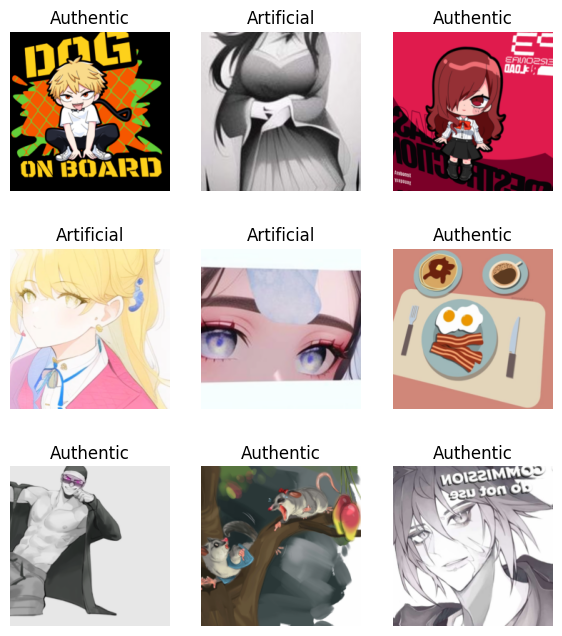

In [ ]:
data.show_batch(nrows=3, figsize=(7,8))

In [ ]:
#Customized model (model1,model2)
model1 = timm.create_model('resnet50', pretrained=True)
model2 = timm.create_model('efficientnet_b0', pretrained=True)

class CustomModel(nn.Module):
    def __init__(self, model1, model2, num_classes):
        super().__init__()
        self.model1 = model1
        self.model2 = model2
        self.classifier = nn.Sequential(
            nn.Linear(1000 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x1 = self.model1(x.clone())
        x2 = self.model2(x)
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        x = torch.cat((x1, x2), dim=1)
        x = self.classifier(x)
        return x

custom_model = CustomModel(model1, model2, num_classes=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,1.037297,0.650197,0.607143,0.952381,0.563380,0.707965,02:18
1,0.642880,0.248889,0.880952,0.880952,0.880952,0.880952,01:33
2,0.429402,0.385992,0.892857,1.000000,0.823529,0.903226,01:34
3,0.359348,0.209073,0.940476,0.952381,0.930233,0.941176,01:32
4,0.290925,0.839074,0.726190,0.452381,1.000000,0.622951,01:30
5,0.250730,0.162368,0.940476,0.976190,0.911111,0.942529,01:32
6,0.215489,0.393197,0.904762,0.857143,0.947368,0.900000,01:30
7,0.202855,0.990636,0.857143,0.761905,0.941176,0.842105,01:33
8,0.165774,0.719410,0.845238,0.714286,0.967742,0.821918,01:33
9,0.251081,1.140311,0.797619,0.952381,0.727273,0.824742,01:32


No improvement since epoch 5: early stopping


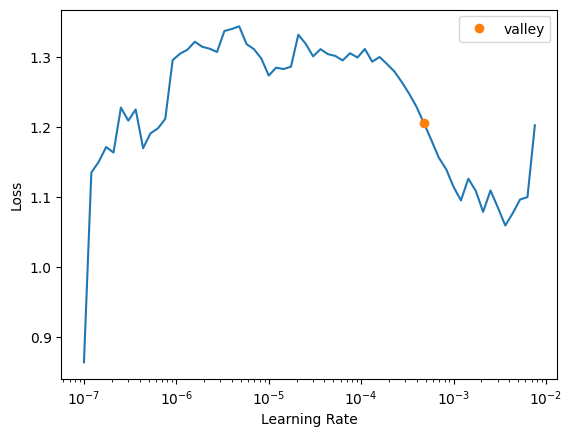

In [ ]:
learn = Learner(data, custom_model, opt_func=Adam, lr=0.001, metrics=[accuracy, Recall(), Precision(), F1Score()])

# Early stopping callback
early_stopping = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3)
learn.add_cb(early_stopping)

learn.lr_find()

learn.fit_one_cycle(20, slice(1e-4, 1e-3))

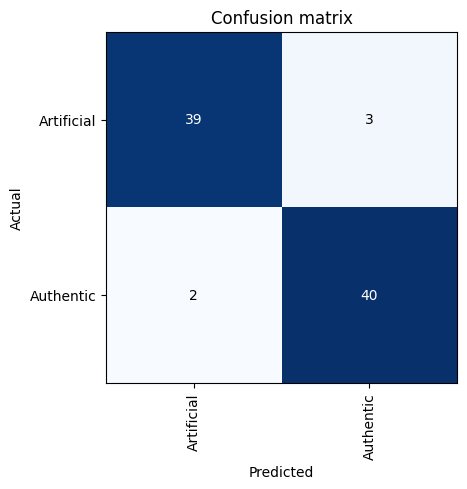

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
folder_path = "/content/drive/MyDrive/Proj/test/"

authentic_count = 0
artificial_count = 0
incorrect_authentic_count = 0
incorrect_artificial_count = 0
correct_count = 0
incorrect_count = 0

# Finds the numnber of correct/incorrect classified images
for file_name in os.listdir(folder_path):
    if file_name.endswith(".jpg") or file_name.endswith(".png"):
        img = PILImage.create(os.path.join(folder_path, file_name))

        pred_class, _, _ = learn.predict(img)

        print(f"File: {file_name}, Predicted Class: {pred_class}")

        true_class = "Artificial" if file_name.endswith("-ai.jpg") else "Authentic"
        if pred_class == true_class:
            correct_count += 1
            if true_class == "Authentic":
                authentic_count += 1
            else:
                artificial_count += 1
        else:
            incorrect_count += 1
            if true_class == "Authentic":
                incorrect_authentic_count += 1
            else:
                incorrect_artificial_count += 1

print(f"Number of images correctly predicted: {correct_count}")
print(f"Number of images incorrectly predicted: {incorrect_count}")
print(f"Number of authentic images: {authentic_count}")
print(f"Number of artificial images: {artificial_count}")
print(f"Number of incorrectly predicted authentic images: {incorrect_authentic_count}")
print(f"Number of incorrectly predicted artificial images: {incorrect_artificial_count}")


File: a8-ai.jpg, Predicted Class: Artificial


File: a14-ai.jpg, Predicted Class: Artificial


File: a9-ai.jpg, Predicted Class: Artificial


File: a23-ai.jpg, Predicted Class: Authentic


File: a12-ai.jpg, Predicted Class: Artificial


File: a33-ai.jpg, Predicted Class: Artificial


File: a17-ai.jpg, Predicted Class: Artificial


File: a6-ai.png, Predicted Class: Authentic


File: a34-ai.jpg, Predicted Class: Artificial


File: a10-ai.jpg, Predicted Class: Artificial


File: a28-ai.jpg, Predicted Class: Artificial


File: a7-ai.jpg, Predicted Class: Artificial


File: a24-ai.jpg, Predicted Class: Authentic


File: a19-ai.jpg, Predicted Class: Artificial


File: a18-ai.jpg, Predicted Class: Artificial


File: a1-ai.png, Predicted Class: Authentic


File: a26-ai.jpg, Predicted Class: Artificial


File: a4-ai.png, Predicted Class: Authentic


File: a37-ai.jpg, Predicted Class: Artificial


File: a40-ai.jpg, Predicted Class: Artificial


File: a16-ai.jpg, Predicted Class: Authentic


File: a30-ai.jpg, Predicted Class: Artificial


File: a31-ai.jpg, Predicted Class: Artificial


File: a22-ai.jpg, Predicted Class: Artificial


File: a39-ai.jpg, Predicted Class: Authentic


File: a11-ai.jpg, Predicted Class: Artificial


File: a3-ai.png, Predicted Class: Authentic


File: a20-ai.jpg, Predicted Class: Artificial


File: a41-ai.jpg, Predicted Class: Artificial


File: a35-ai.jpg, Predicted Class: Artificial


File: a2-ai.jpg, Predicted Class: Artificial


File: a21-ai.jpg, Predicted Class: Artificial


File: a25-ai.jpg, Predicted Class: Artificial


File: a15-ai.jpg, Predicted Class: Artificial


File: a36-ai.jpg, Predicted Class: Artificial


File: a6.jpg, Predicted Class: Authentic


File: a13.jpg, Predicted Class: Authentic


File: a29-ai.jpg, Predicted Class: Authentic


File: a13-ai.jpg, Predicted Class: Artificial


File: a4.jpg, Predicted Class: Authentic


File: a10.jpg, Predicted Class: Authentic


File: a9.jpg, Predicted Class: Authentic


File: a2.jpg, Predicted Class: Authentic


File: a27-ai.jpg, Predicted Class: Artificial


File: a42-ai.jpg, Predicted Class: Artificial


File: a17.jpg, Predicted Class: Artificial


File: a32-ai.jpg, Predicted Class: Artificial


File: a5-ai.jpg, Predicted Class: Artificial


File: a11.jpg, Predicted Class: Authentic


File: a38-ai.jpg, Predicted Class: Artificial


File: a16.jpg, Predicted Class: Authentic


File: a12.jpg, Predicted Class: Authentic


File: a14.jpg, Predicted Class: Authentic


File: a40.jpg, Predicted Class: Authentic


File: a7.jpg, Predicted Class: Authentic


File: a34.jpg, Predicted Class: Authentic


File: a39.jpg, Predicted Class: Authentic


File: a35.jpg, Predicted Class: Authentic


File: a36.jpg, Predicted Class: Authentic


File: a26.jpg, Predicted Class: Authentic


File: a29.jpg, Predicted Class: Authentic


File: a5.jpg, Predicted Class: Authentic


File: a18.jpg, Predicted Class: Authentic


File: a1.jpg, Predicted Class: Authentic


File: a38.jpg, Predicted Class: Authentic


File: a15.jpg, Predicted Class: Authentic


File: a21.jpg, Predicted Class: Authentic


File: a28.jpg, Predicted Class: Authentic


File: a30.jpg, Predicted Class: Artificial


File: a22.jpg, Predicted Class: Authentic


File: a24.jpg, Predicted Class: Authentic


File: a8.jpg, Predicted Class: Authentic


File: a20.jpg, Predicted Class: Authentic


File: a23.jpg, Predicted Class: Authentic


File: a19.jpg, Predicted Class: Authentic


File: a31.jpg, Predicted Class: Authentic


File: a32.jpg, Predicted Class: Authentic


File: a3.jpg, Predicted Class: Authentic


File: a25.jpg, Predicted Class: Authentic


File: a33.jpg, Predicted Class: Authentic


File: a37.jpg, Predicted Class: Authentic


File: a42.jpg, Predicted Class: Authentic


File: a41.jpg, Predicted Class: Authentic


File: a27.jpg, Predicted Class: Authentic
Number of images correctly predicted: 77
Number of images incorrectly predicted: 7
Number of authentic images: 44
Number of artificial images: 33
Number of incorrectly predicted authentic images: 2
Number of incorrectly predicted artificial images: 5


In [ ]:
#Testing results
TP = authentic_count
TN = artificial_count
FP = incorrect_authentic_count
FN = incorrect_artificial_count

Total = TP + TN + FP + FN

accuracy = (TP + TN) / Total

precision = TP / (TP + FP)

recall = TP / (TP + FN)

f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"f1_score: {f1_score}")

Accuracy: 0.9166666666666666
precision: 0.9565217391304348
recall: 0.8979591836734694
f1_score: 0.9263157894736843
